In [1]:
import numpy as np 
import pandas as pd 
import json
from pandas.io.json import json_normalize
import datetime as dt
import seaborn as sns 
import matplotlib.pyplot as plt 
import plotly.graph_objs as go
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
#init_notebook_mode(connected=True)
import os

In [2]:
#Let's check first the columns and types of train.csv
onerow = pd.read_csv('train.csv',nrows=1)
pd.concat([onerow.T, onerow.dtypes.T], axis=1, keys=['Example', 'Type'])

,Example,Type
,0,0
channelGrouping,Organic Search,object
date,20160902,int64
device,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",object
fullVisitorId,1131660440785968503,int64
geoNetwork,"{""continent"": ""Asia"", ""subContinent"": ""Western...",object
sessionId,1131660440785968503_1472830385,object
socialEngagementType,Not Socially Engaged,object
totals,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...",object
trafficSource,"{""campaign"": ""(not set)"", ""source"": ""google"", ...",object


Let's flatten the json objects.

In [3]:
#the columns that will be parsed to extract the fields from the jsons
cols_to_parse = ['device', 'geoNetwork', 'totals', 'trafficSource']

def read_parse_dataframe(file_name):
    #full path for the data file
    path = file_name
    #read the data file, convert the columns in the list of columns to parse using json loader,
    #convert the `fullVisitorId` field as a string
    data_df = pd.read_csv(path, 
        converters={column: json.loads for column in cols_to_parse}, 
        dtype={'fullVisitorId': 'str'})
    #parse the json-type columns
    for col in cols_to_parse:
        #each column became a dataset, with the columns the fields of the Json type object
        json_col_df = json_normalize(data_df[col])
        json_col_df.columns = [str(col+"_"+sub_col) for sub_col in json_col_df.columns]
        #we drop the object column processed and we add the columns created from the json fields
        data_df = data_df.drop(col, axis=1).merge(json_col_df, right_index=True, left_index=True)
    return data_df

In [4]:
%%time
train_df = read_parse_dataframe('train.csv')

CPU times: user 1min 45s, sys: 3.56 s, total: 1min 49s
Wall time: 1min 51s


In [5]:
print("Train set:",train_df.shape[0]," rows, ", train_df.shape[1],"columns")

Train set: 903653  rows,  55 columns


In [6]:
train_df.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device_browser,device_browserSize,...,trafficSource_adwordsClickInfo.isVideoAd,trafficSource_adwordsClickInfo.page,trafficSource_adwordsClickInfo.slot,trafficSource_campaign,trafficSource_campaignCode,trafficSource_isTrueDirect,trafficSource_keyword,trafficSource_medium,trafficSource_referralPath,trafficSource_source
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,google + online,organic,NaN,google
4,Organic Search,20160902,27294437909732085,27294437909732085_1472822600,Not Socially Engaged,1472822600,2,1472822600,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,True,(not provided),organic,NaN,google


It seems that sessionId is the result of concatenating fullVisitorId with visitId. The field visitStartTime seems to be almost(!!! - 4709 are different, all others are the same) identical with visitId and also it is most probably the timestamp. Let's check if the value of first visitId is a timestamp.

In [7]:
print(dt.datetime.fromtimestamp(train_df['visitId'][0]).isoformat())

2016-09-02T08:33:05


Let's extract date and time from the date field.

In [8]:
def process_date_time(data_df):
    data_df['date'] = data_df['date'].astype(str)
    data_df["date"] = data_df["date"].apply(lambda x : x[:4] + "-" + x[4:6] + "-" + x[6:])
    data_df["date"] = pd.to_datetime(data_df["date"])   
    data_df["year"] = data_df['date'].dt.year
    data_df["month"] = data_df['date'].dt.month
    data_df["day"] = data_df['date'].dt.day
    data_df["weekday"] = data_df['date'].dt.weekday
    return data_df

train_df = process_date_time(train_df)

Let's check again the dataset shape.

In [9]:
print("Train set:",train_df.shape[0]," rows, ", train_df.shape[1],"columns")

Train set: 903653  rows,  59 columns


Let's load also the test data. Then, let's process similarly the test data.

In [10]:
%%time
test_df = read_parse_dataframe('test.csv')
test_df = process_date_time(test_df)

CPU times: user 1min 42s, sys: 2.31 s, total: 1min 44s
Wall time: 1min 46s


In [11]:
print("Test set:",test_df.shape[0]," rows, ", test_df.shape[1],"columns")

Test set: 804684  rows,  57 columns


Columns with missing data

In [12]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    df = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return df.loc[~(df['Total']==0)]
missing_data(train_df)

,Total,Percent
trafficSource_campaignCode,903652,99.999889
trafficSource_adContent,892707,98.788694
totals_transactionRevenue,892138,98.725728
trafficSource_adwordsClickInfo.page,882193,97.625195
trafficSource_adwordsClickInfo.adNetworkType,882193,97.625195
trafficSource_adwordsClickInfo.slot,882193,97.625195
trafficSource_adwordsClickInfo.isVideoAd,882193,97.625195
trafficSource_adwordsClickInfo.gclId,882092,97.614018
trafficSource_isTrueDirect,629648,69.678073
trafficSource_referralPath,572712,63.377425


In [13]:
missing_data(test_df)

,Total,Percent
trafficSource_adContent,750893,93.315264
trafficSource_adwordsClickInfo.page,750870,93.312406
trafficSource_adwordsClickInfo.adNetworkType,750870,93.312406
trafficSource_adwordsClickInfo.slot,750870,93.312406
trafficSource_adwordsClickInfo.isVideoAd,750870,93.312406
trafficSource_adwordsClickInfo.gclId,750822,93.306441
trafficSource_referralPath,569361,70.755850
trafficSource_isTrueDirect,544171,67.625428
trafficSource_keyword,391032,48.594479
totals_bounces,383736,47.687788




A part of the features with very high missing data percent in the train data have a lower percent of the missing data in the test set (~93%) and also there are some that are not appearing in the list with fields with missing values in the test.
We can also see that there are fields that does appears only in the train and set, for example trafficSource_campaignCode . We will have to consider these aspects when we will decide what features to drop and what features to keep for the predictive model.

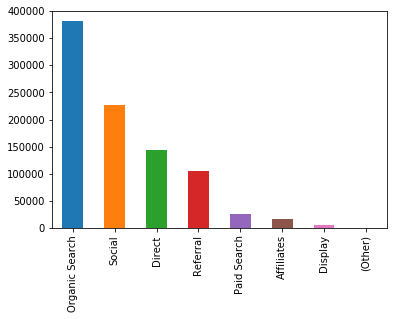

In [27]:
#channelGrouping
channel = train_df["channelGrouping"].value_counts()
channel.plot.bar()

In [28]:
def get_feature_distribution(data, feature):
    # Get the count for each label
    label_counts = data[feature].value_counts()

    # Get total number of samples
    total_samples = len(data)

    # Count the number of items in each class
    for i in range(len(label_counts)):
        label = label_counts.index[i]
        count = label_counts.values[i]
        percent = int((count / total_samples) * 10000)/100
        print("{:<30s}:   {} or {}%".format(label, count, percent))

get_feature_distribution(train_df,'channelGrouping')

Organic Search                :   381561 or 42.22%
Social                        :   226117 or 25.02%
Direct                        :   143026 or 15.82%
Referral                      :   104838 or 11.6%
Paid Search                   :   25326 or 2.8%
Affiliates                    :   16403 or 1.81%
Display                       :   6262 or 0.69%
(Other)                       :   120 or 0.01%


In [29]:
get_feature_distribution(train_df,'socialEngagementType')

Not Socially Engaged          :   903653 or 100.0%


We should drop this one

In [30]:
#device fields
device_cols = train_df.columns[train_df.columns.str.contains('device')].T.tolist()
print("There are ",len(device_cols),"columns with device attributes:\n",device_cols)

There are  16 columns with device attributes:
 ['device_browser', 'device_browserSize', 'device_browserVersion', 'device_deviceCategory', 'device_flashVersion', 'device_isMobile', 'device_language', 'device_mobileDeviceBranding', 'device_mobileDeviceInfo', 'device_mobileDeviceMarketingName', 'device_mobileDeviceModel', 'device_mobileInputSelector', 'device_operatingSystem', 'device_operatingSystemVersion', 'device_screenColors', 'device_screenResolution']


In [36]:
#checking for uniqness
const_device_cols = []
for i, col in enumerate(device_cols):
    if(len(train_df[col].value_counts())==1):
        if (train_df[col].value_counts()[0] == train_df.shape[0]):
            const_device_cols.append(col)
print("There are ",len(const_device_cols),"columns with unique value for device attributes:\n",const_device_cols)

There are  12 columns with unique value for device attributes:
 ['device_browserSize', 'device_browserVersion', 'device_flashVersion', 'device_language', 'device_mobileDeviceBranding', 'device_mobileDeviceInfo', 'device_mobileDeviceMarketingName', 'device_mobileDeviceModel', 'device_mobileInputSelector', 'device_operatingSystemVersion', 'device_screenColors', 'device_screenResolution']


We should drop those

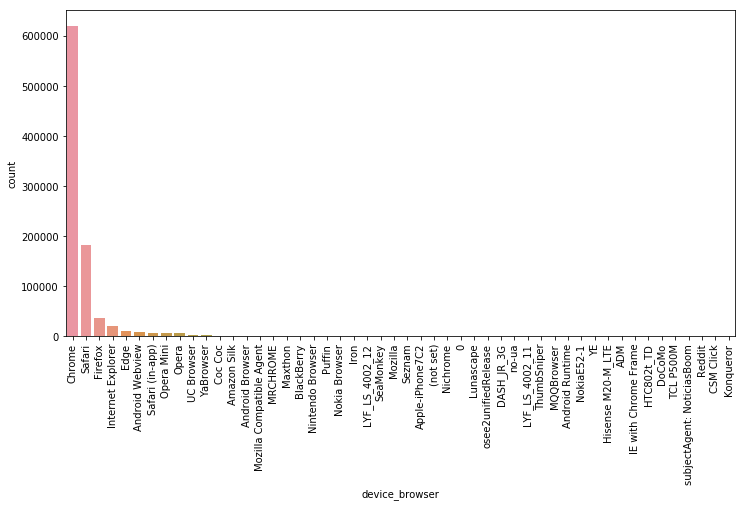

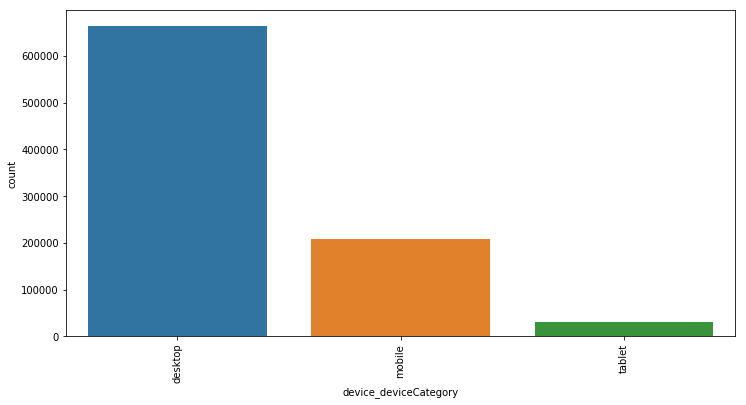

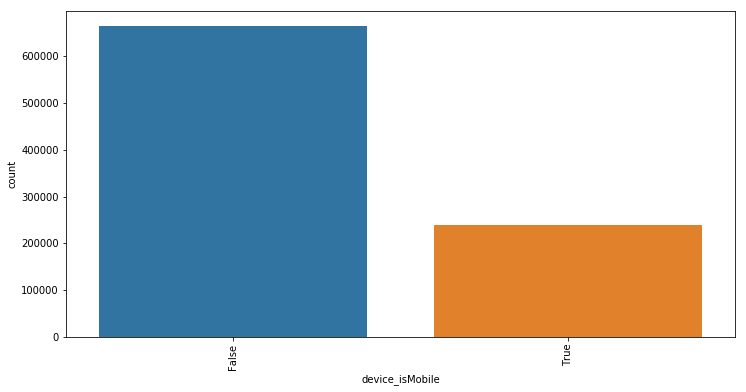

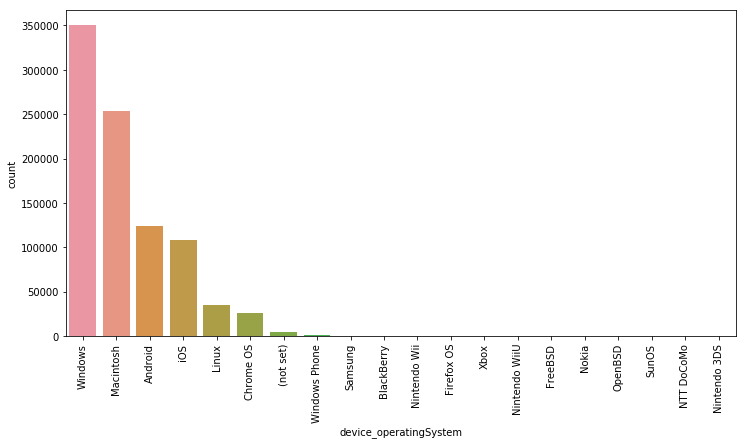

In [37]:
def show_features(data,features,width=6,height=6):
    for i,feature in enumerate(features):
        f, ax = plt.subplots(1,1, figsize=(width,height))
        sns.countplot(data[feature],order = data[feature].value_counts().iloc[:50].index)
        plt.xticks(rotation=90)
        plt.show()



var_cols = [item for item in device_cols if item not in const_device_cols]
show_features(train_df,var_cols, width=12,height=6)



The majority of the visits are using devices with Windows OS, Chrome browser, from a Desktop. From the mobile devices, majority are phones.

The most used OS are: Windows, Macintosh, Android, iOS and Linux.
The most used browsers are Chrome, Safari, Firefox, Internet Explorer and Edge.
Let's check few of these features correlation.


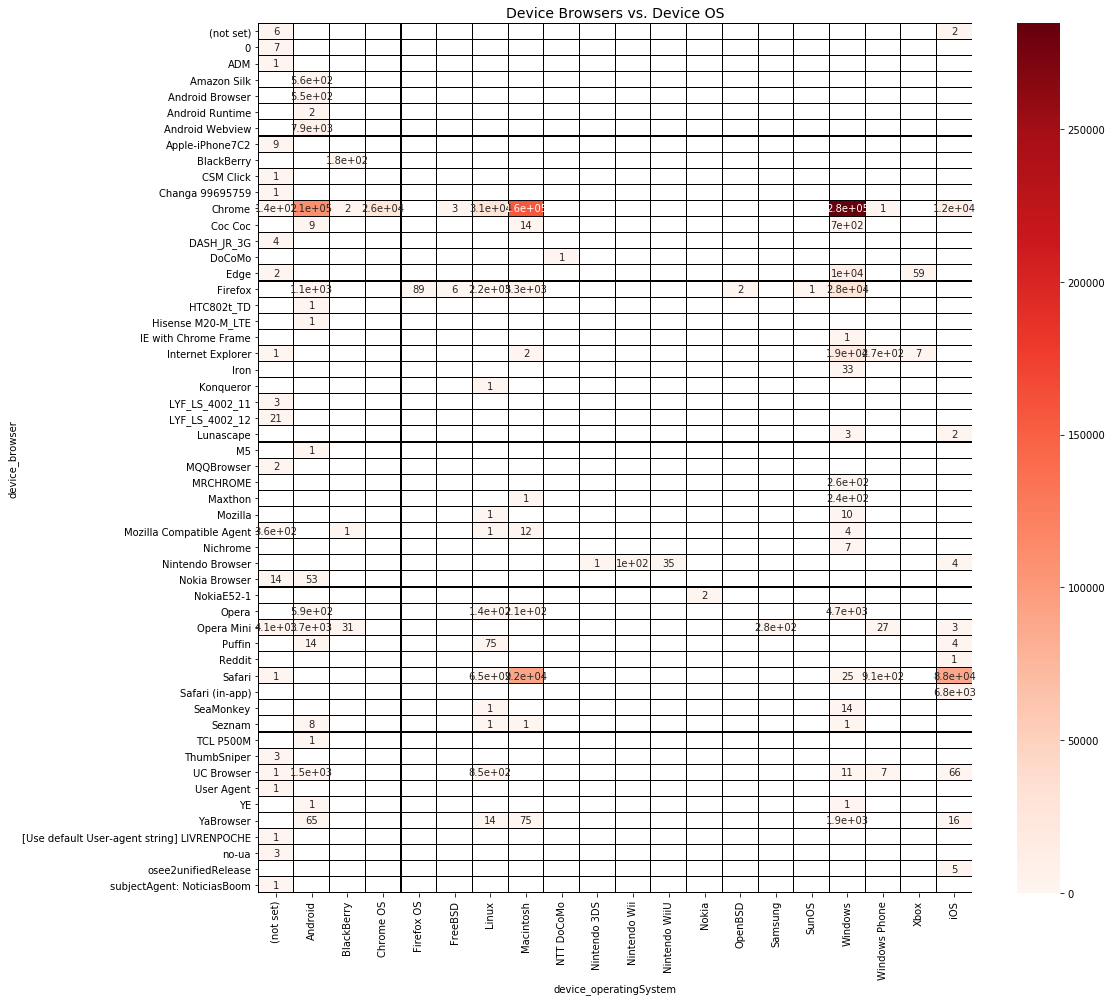

In [40]:
def plot_heatmap_count(data_df, feature1, feature2, feature3='channelGrouping', color="Greens", title="", height=16, width=16):
    tmp = data_df.groupby([feature1, feature2])[feature3].count()
    df1 = tmp.reset_index()
    matrix = df1.pivot(feature1, feature2, feature3)
    fig, (ax1) = plt.subplots(ncols=1, figsize=(width,height))
    sns.heatmap(matrix, 
        xticklabels=matrix.columns,
        yticklabels=matrix.index,ax=ax1,linewidths=.1,linecolor='black',annot=True,cmap=color)
    plt.title(title, fontsize=14)
    plt.show()

def plot_heatmap_sum(data_df, feature1, feature2, feature3='channelGrouping', color="Greens", title="", height=16, width=16):
    tmp = data_df.groupby([feature1, feature2])[feature3].sum()
    df1 = tmp.reset_index()
    matrix = df1.pivot(feature1, feature2, feature3)
    fig, (ax1) = plt.subplots(ncols=1, figsize=(width,height))
    sns.heatmap(matrix, 
        xticklabels=matrix.columns,
        yticklabels=matrix.index,ax=ax1,linewidths=.1,linecolor='black',annot=True,cmap=color)
    plt.title(title, fontsize=14)
    plt.show()
    
plot_heatmap_count(train_df, 'device_browser', 'device_operatingSystem',color='Reds',title="Device Browsers vs. Device OS")



Chrome with Windows are the most frequent combination, followed by Chrome with Macintosh, Chrome with Android and Safari with Macintosh and Safari with iOS.


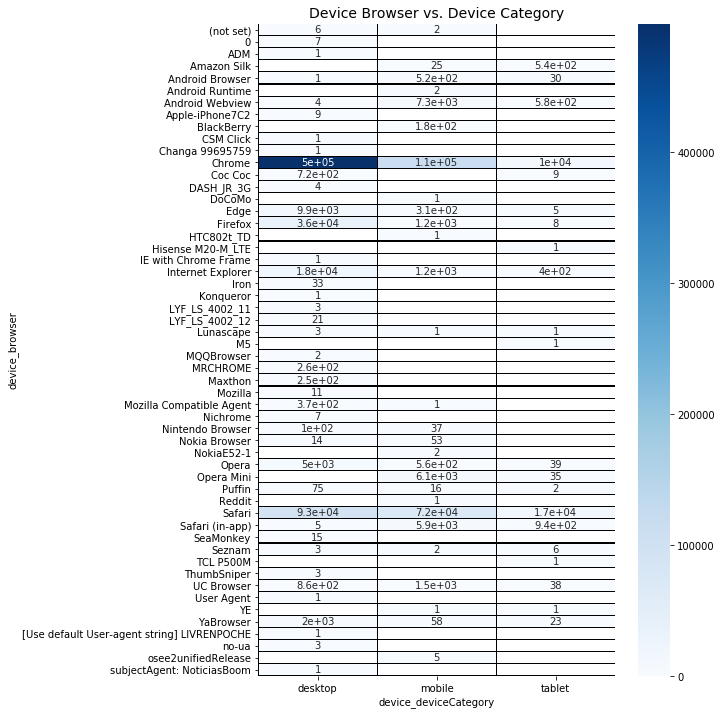

In [41]:


plot_heatmap_count(train_df, 'device_browser','device_deviceCategory', color='Blues',title="Device Browser vs. Device Category", height=12, width=8)





Chrome on Desktop is the most frequent browser-category device combination, followed by Chrome with mobile and Safari with desktop and with mobile.


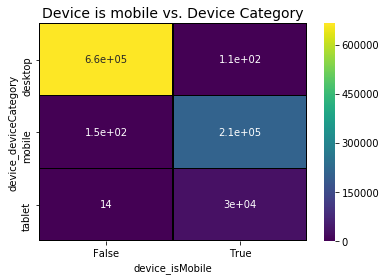

In [42]:


plot_heatmap_count(train_df, 'device_deviceCategory', 'device_isMobile', color='viridis',title="Device is mobile vs. Device Category", width=6, height=4)





We can observe that there are both Desktop that appears as mobile (110) device and tablet (14) and mobile (150) set as not mobile.

In [44]:
#geographic terms
geo_cols = train_df.columns[train_df.columns.str.contains('geoNetwork')].T.tolist()
print("There are ",len(geo_cols),"columns with geoNetwork attributes:\n",geo_cols)

There are  11 columns with geoNetwork attributes:
 ['geoNetwork_city', 'geoNetwork_cityId', 'geoNetwork_continent', 'geoNetwork_country', 'geoNetwork_latitude', 'geoNetwork_longitude', 'geoNetwork_metro', 'geoNetwork_networkDomain', 'geoNetwork_networkLocation', 'geoNetwork_region', 'geoNetwork_subContinent']


In [46]:
const_geo_cols = []
for i, col in enumerate(geo_cols):
    if(len(train_df[col].value_counts())==1):
        if (train_df[col].value_counts()[0] == train_df.shape[0]):
            const_geo_cols.append(col)
print("There are ",len(const_geo_cols),"columns with unique value for geoNetwork attributes:\n",const_geo_cols)

There are  4 columns with unique value for geoNetwork attributes:
 ['geoNetwork_cityId', 'geoNetwork_latitude', 'geoNetwork_longitude', 'geoNetwork_networkLocation']


These columns are candidates to be dropped from the model. For the rest of the columns, we show the number of the visits per each attribute. Note: We limit the number of shown values/categories to 50, showing the most numerous first.

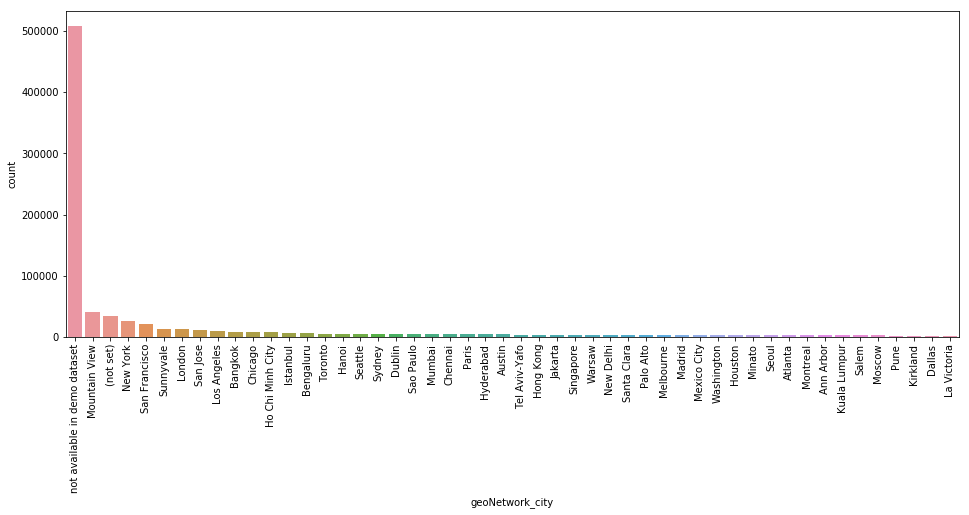

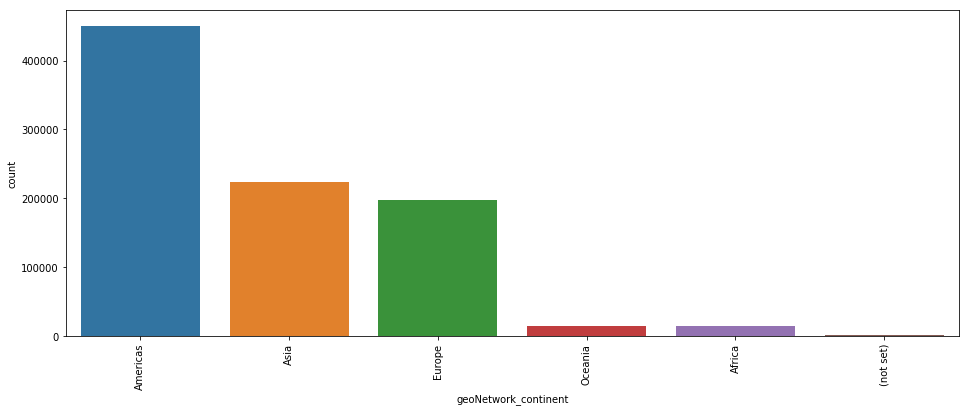

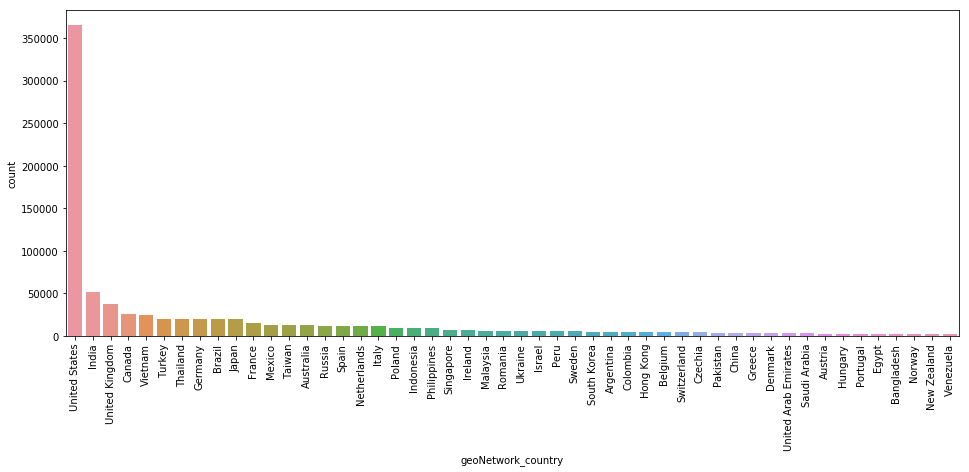

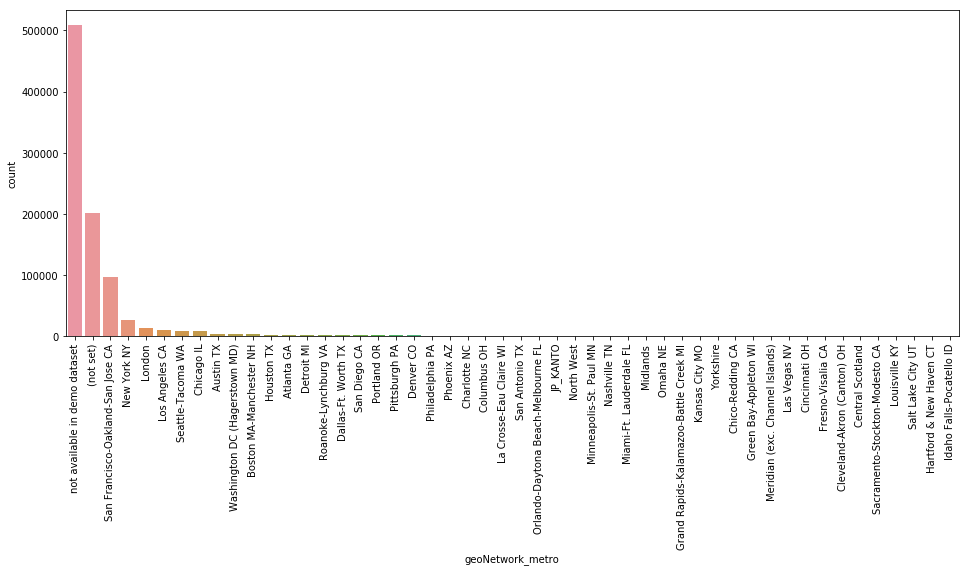

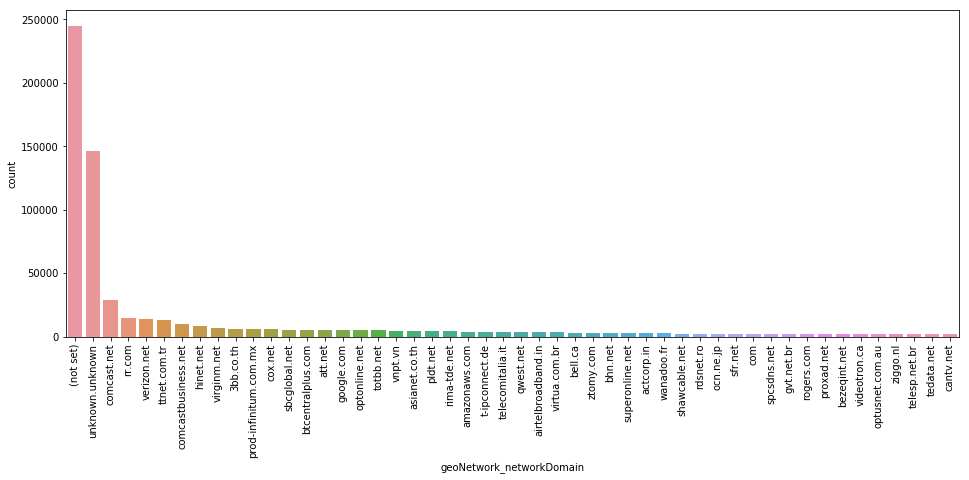

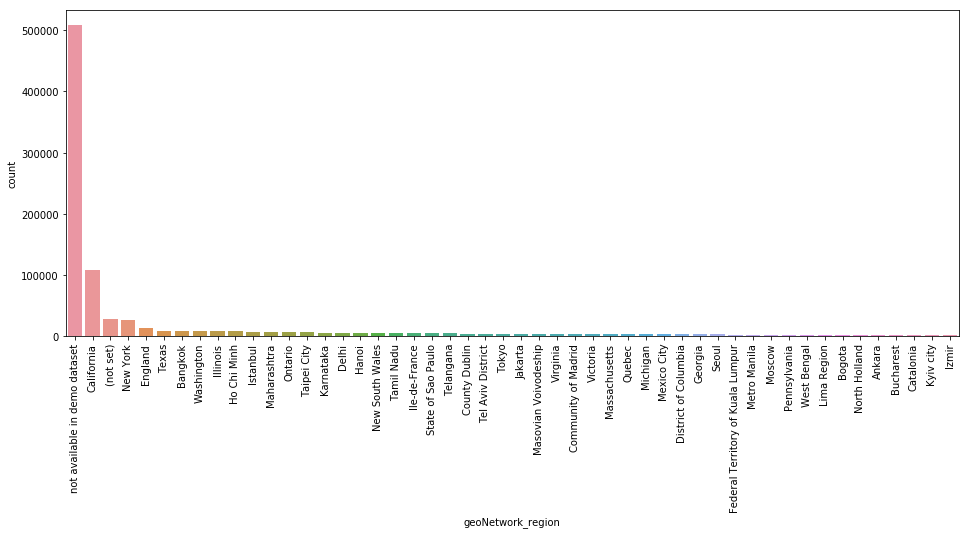

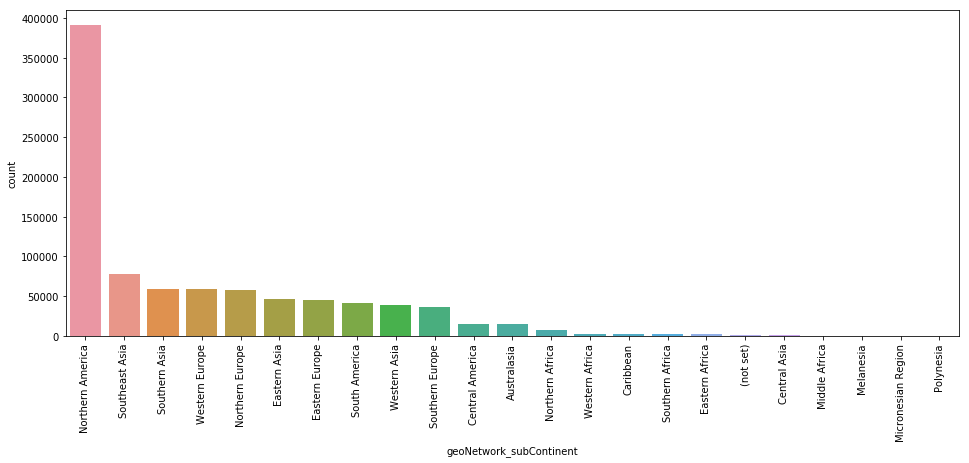

In [47]:
var_cols = [item for item in geo_cols if item not in const_geo_cols]
show_features(train_df,var_cols,16,6)

In [55]:
tmp = train_df['geoNetwork_country'].value_counts()
country_visits = pd.DataFrame(data={'geoNetwork_country': tmp.values}, index=tmp.index).reset_index()
country_visits.columns = ['Country', 'Visits']

def plot_country_map(data, location, z, legend, title, colormap='Rainbow'):
    data = dict(type = 'choropleth', 
                colorscale = colormap,
                autocolorscale = False,
                reversescale = False,
               locations = data[location],
               locationmode = 'country names',
               z = data[z], 
               text = data[z],
               colorbar = {'title':legend})
    layout = dict(title = title, 
                 geo = dict(showframe = False, 
                         projection = {'type': 'natural earth'}))
    choromap = go.Figure(data = [data], layout=layout)
    plot(choromap)

In [56]:
plot_country_map(country_visits, 'Country', 'Visits', 'Visits', 'Visits per country')

In [57]:
#total attributes
tot_cols = train_df.columns[train_df.columns.str.contains('totals')].T.tolist()
print("There are ",len(tot_cols),"columns with Totals attributes:\n",tot_cols)

There are  6 columns with Totals attributes:
 ['totals_bounces', 'totals_hits', 'totals_newVisits', 'totals_pageviews', 'totals_transactionRevenue', 'totals_visits']


In [59]:
const_tot_cols = []
for i, col in enumerate(tot_cols):
    if(len(train_df[col].value_counts())==1):
        print(train_df[col].value_counts())
        #const_tot_cols.append(col)
#print("There are ",len(const_tot_cols),"columns with unique value for Totals attributes:\n",const_tot_cols)

1    450630
Name: totals_bounces, dtype: int64
1    703060
Name: totals_newVisits, dtype: int64
1    903653
Name: totals_visits, dtype: int64


Total bounces and newVisits have NaN values

In [60]:
for i, col in enumerate(tot_cols):
    if(len(train_df[col].value_counts())==1):
        if (train_df[col].value_counts()[0] == train_df.shape[0]):
            const_tot_cols.append(col)

print("There are ",len(const_tot_cols),"columns with unique value for Totals attributes:\n",const_tot_cols)

There are  1 columns with unique value for Totals attributes:
 ['totals_visits']


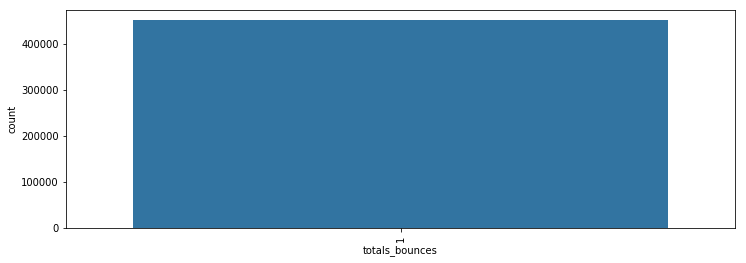

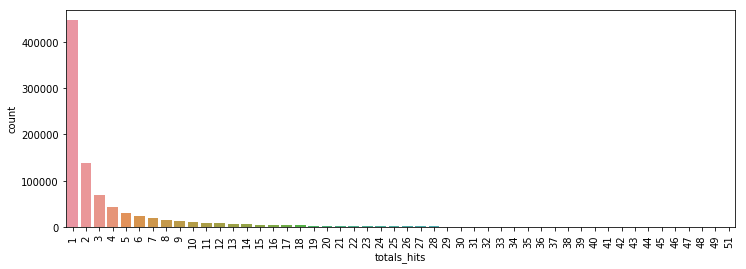

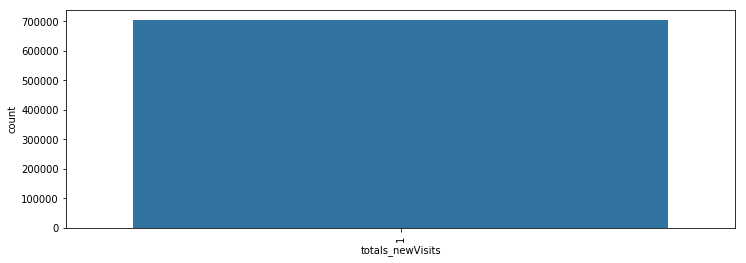

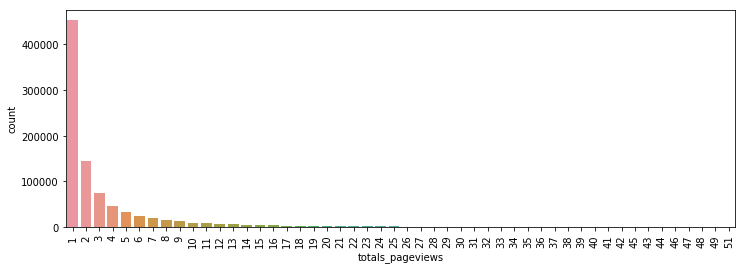

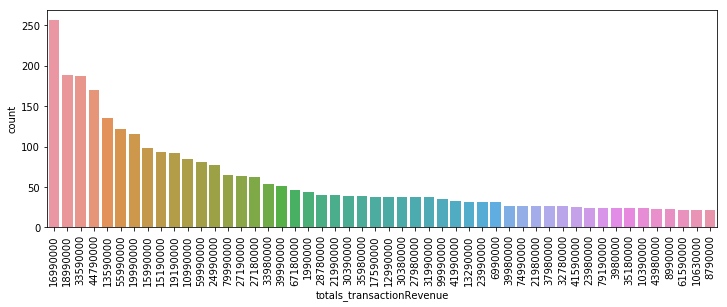

In [61]:
var_cols = [item for item in tot_cols if item not in const_tot_cols]
show_features(train_df,var_cols,12,4)

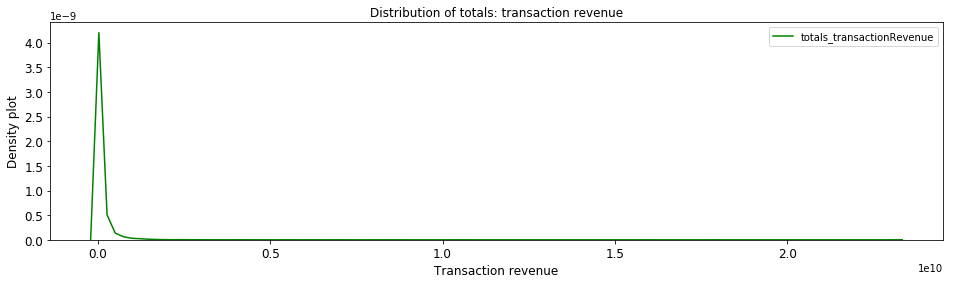

In [62]:
train_df['totals_transactionRevenue'] = pd.to_numeric(train_df['totals_transactionRevenue'])
df = train_df[train_df['totals_transactionRevenue'] > 0]['totals_transactionRevenue']
f, ax = plt.subplots(1,1, figsize=(16,4))
plt.title("Distribution of totals: transaction revenue")
sns.kdeplot(df, color="green")
plt.tick_params(axis='both', which='major', labelsize=12)
plt.ylabel('Density plot', fontsize=12)
plt.xlabel('Transaction revenue', fontsize=12)
locs, labels = plt.xticks()
plt.show()

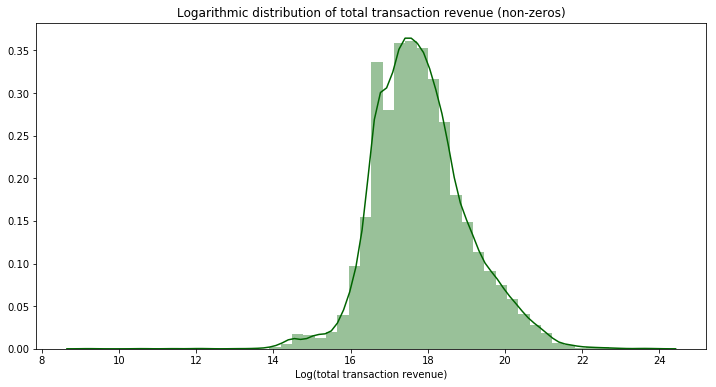

In [64]:
plt.figure(figsize=(12,6))
sns.distplot(np.log(df),color="darkgreen",bins=50)
plt.xlabel("Log(total transaction revenue)");
plt.title("Logarithmic distribution of total transaction revenue (non-zeros)");

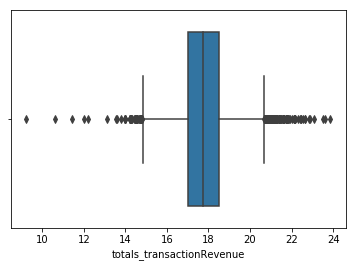

In [65]:
sns.boxplot(np.log(df))

In [66]:
# select the visits with non-zero transaction revenue
non_zero = train_df[train_df['totals_transactionRevenue']>0]
tmp = non_zero['geoNetwork_country'].value_counts()
country_visits = pd.DataFrame(data={'geoNetwork_country': tmp.values}, index=tmp.index).reset_index()
country_visits.columns = ['Country', 'Visits']

plot_country_map(country_visits, 'Country', 'Visits', 'Visits', 'Visits with non zero transactions')

In [68]:
# select the visits with non-zero transaction revenue and calculate the sums
non_zero = train_df[train_df['totals_transactionRevenue']>0]
tmp = non_zero.groupby(['geoNetwork_country'])['totals_transactionRevenue'].sum()
country_total = pd.DataFrame(data={'total': tmp.values}, index=tmp.index).reset_index()
country_total.columns = ['Country', 'Total']
country_total['Total']  = np.log1p(country_total['Total'])

plot_country_map(country_total, 'Country', 'Total', 'Total(log)', 'Total revenues per country (log scale)')

In [69]:
#Let's check the top 10 of the transaction revenue.
non_zero[['fullVisitorId','visitNumber', 'totals_transactionRevenue', 'channelGrouping']].sort_values(['totals_transactionRevenue', 'fullVisitorId'], ascending=[0,0]).head(10)


,fullVisitorId,visitNumber,totals_transactionRevenue,channelGrouping
375253,1957458976293878100,243,2.312950e+10,Display
430822,1957458976293878100,181,1.785550e+10,Direct
380988,5632276788326171571,5,1.602375e+10,Direct
773715,9417857471295131045,8,1.058914e+10,Direct
891576,1957458976293878100,237,8.677830e+09,Display
715264,4471415710206918415,43,8.248800e+09,Referral
629767,7496147812697146114,2,6.996500e+09,Referral
843293,1957458976293878100,245,6.826960e+09,Display
572866,79204932396995037,6,6.248750e+09,Organic Search
799542,1957458976293878100,258,5.614440e+09,Display


In [70]:
#Let's check also the top 10 of visit number.
non_zero[['fullVisitorId','visitNumber', 'totals_transactionRevenue', 'channelGrouping']].sort_values(['visitNumber', 'totals_transactionRevenue'], ascending=[0,0]).head(10)

,fullVisitorId,visitNumber,totals_transactionRevenue,channelGrouping
41081,1957458976293878100,315,1.196740e+09,Display
822787,1957458976293878100,312,2.495000e+09,Display
807547,1957458976293878100,305,2.332560e+09,Display
375896,1957458976293878100,303,2.577000e+07,Display
451107,1957458976293878100,300,2.396000e+07,Display
451183,1957458976293878100,299,1.734400e+08,Display
816339,1957458976293878100,296,1.424250e+09,Display
348275,1957458976293878100,295,2.344000e+08,Display
760007,1957458976293878100,293,4.099600e+08,Display
812087,1957458976293878100,259,3.670920e+09,Display


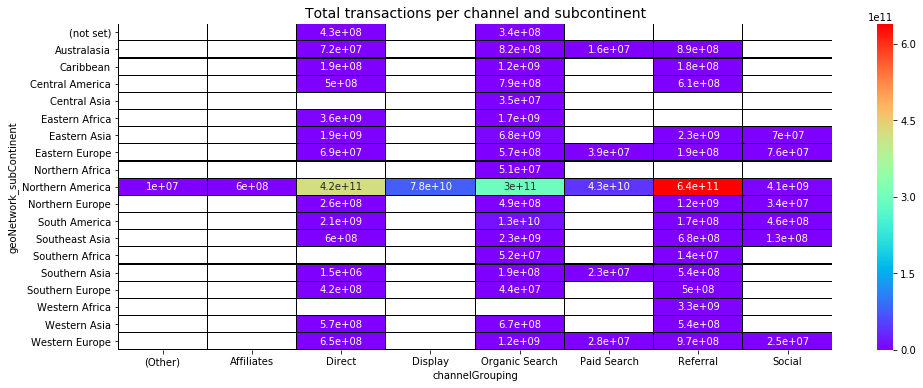

In [71]:
# select the visits with non-zero transaction revenue and calculate the sums
non_zero = train_df[train_df['totals_transactionRevenue']>0]
tmp = non_zero.groupby(['channelGrouping', 'geoNetwork_subContinent'])['totals_transactionRevenue'].sum()
channel_total = pd.DataFrame(data={'total': tmp.values}, index=tmp.index).reset_index()
channel_total.columns = ['Channel', 'Subcontinent', 'Total']

plot_heatmap_sum(non_zero, 'geoNetwork_subContinent','channelGrouping',  'totals_transactionRevenue','rainbow',"Total transactions per channel and subcontinent", width=16, height=6)

Most of the transaction revenues are from Northern America, with Refferal, Direct and Organic Search channel.

In [72]:
#trafficSource
ts_cols = train_df.columns[train_df.columns.str.contains('trafficSource')].T.tolist()
print("There are ",len(ts_cols),"columns with Totals attributes:\n",ts_cols)

There are  14 columns with Totals attributes:
 ['trafficSource_adContent', 'trafficSource_adwordsClickInfo.adNetworkType', 'trafficSource_adwordsClickInfo.criteriaParameters', 'trafficSource_adwordsClickInfo.gclId', 'trafficSource_adwordsClickInfo.isVideoAd', 'trafficSource_adwordsClickInfo.page', 'trafficSource_adwordsClickInfo.slot', 'trafficSource_campaign', 'trafficSource_campaignCode', 'trafficSource_isTrueDirect', 'trafficSource_keyword', 'trafficSource_medium', 'trafficSource_referralPath', 'trafficSource_source']


In [77]:
const_ts_cols = []
for i, col in enumerate(ts_cols):
    if(len(train_df[col].value_counts())==1):
            const_ts_cols.append(col)
        
print("There are ",len(const_ts_cols),"columns with unique value for Traffic Source attributes:\n",const_ts_cols)

There are  4 columns with unique value for Traffic Source attributes:
 ['trafficSource_adwordsClickInfo.criteriaParameters', 'trafficSource_adwordsClickInfo.isVideoAd', 'trafficSource_campaignCode', 'trafficSource_isTrueDirect']


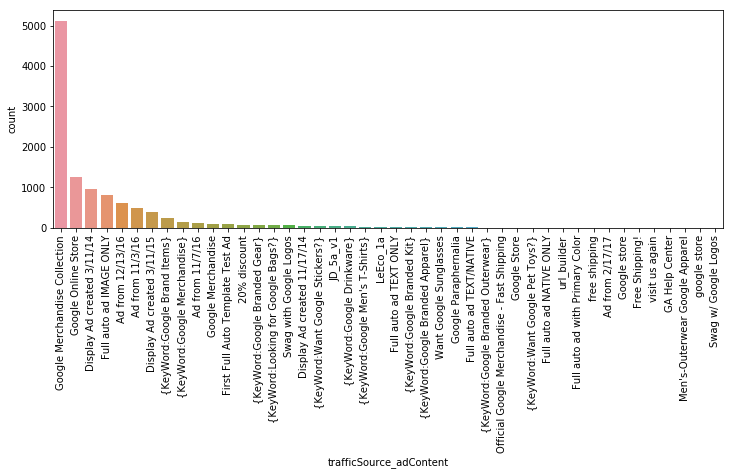

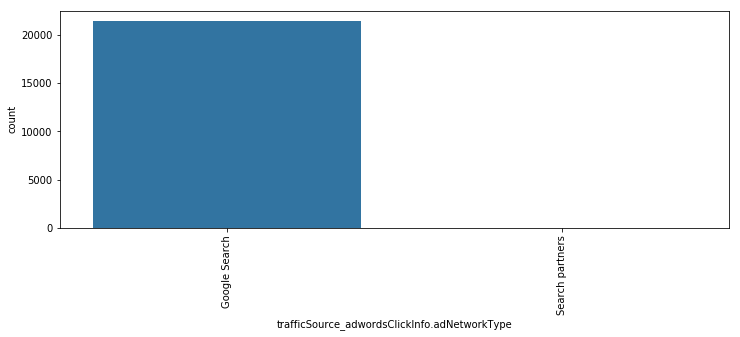

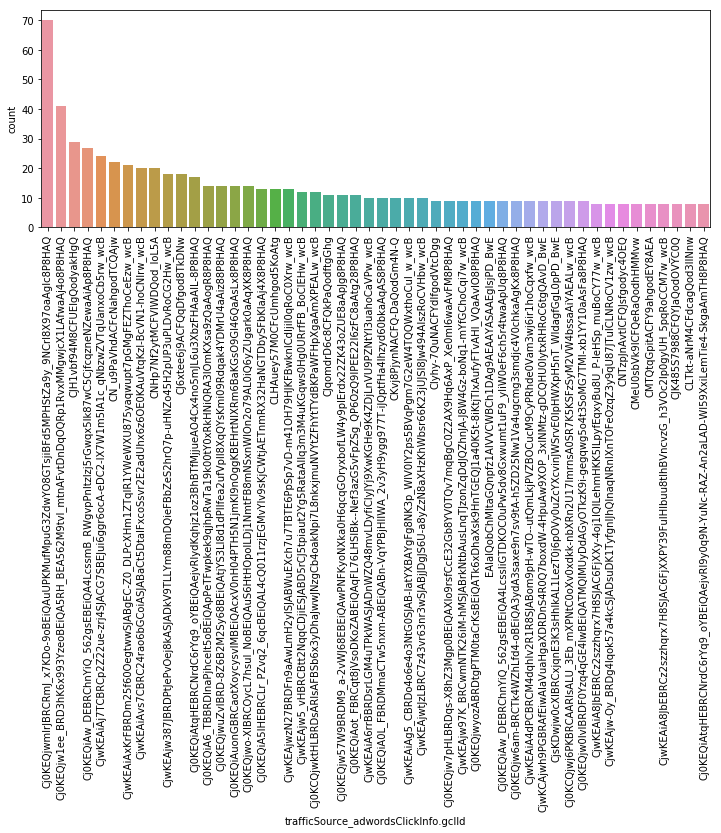

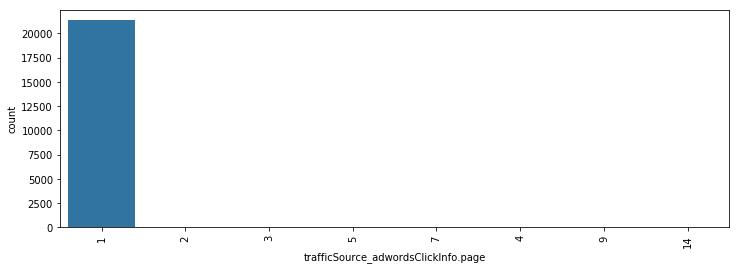

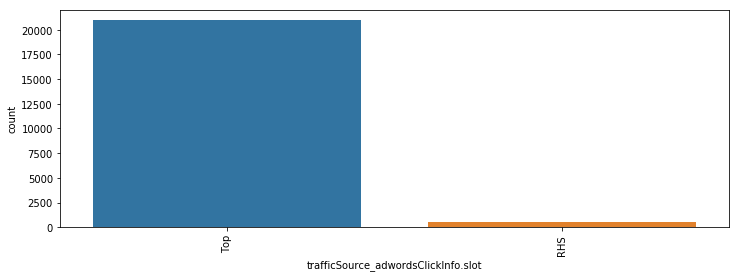

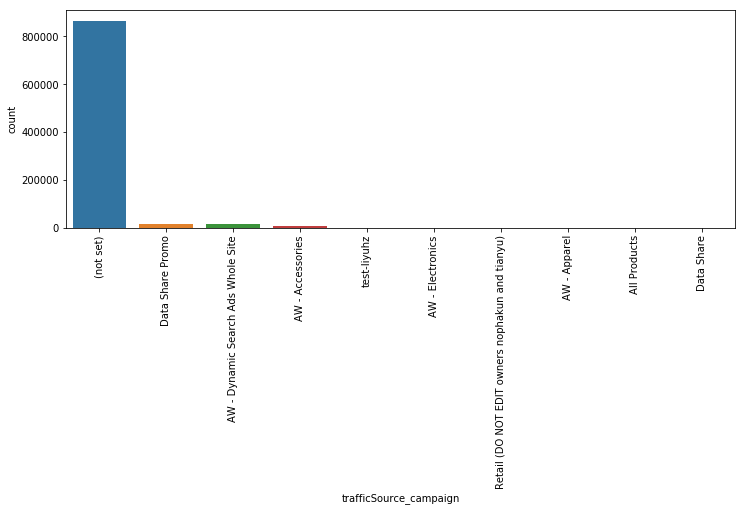

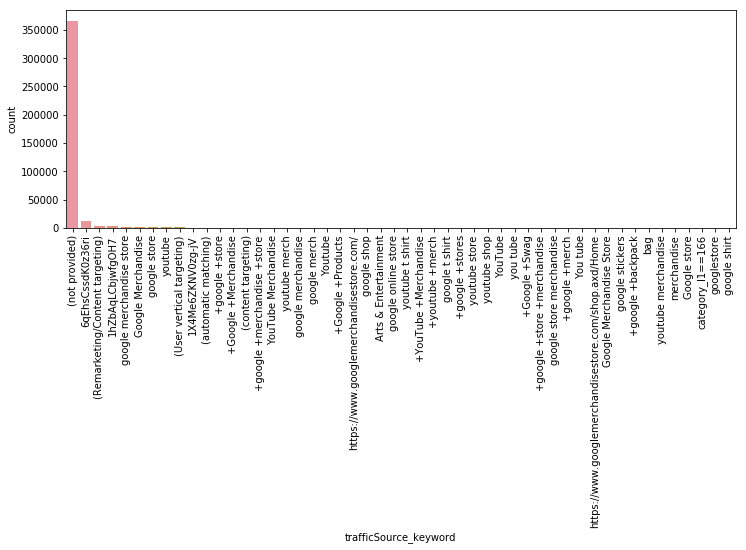

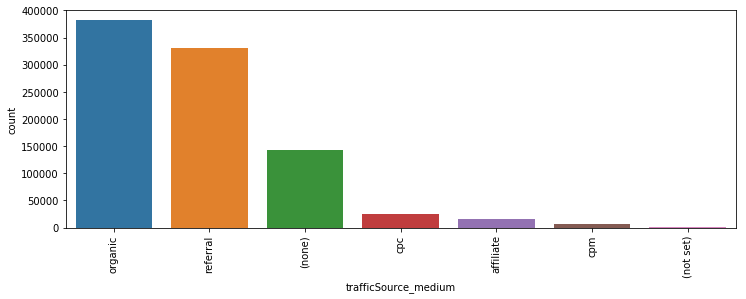

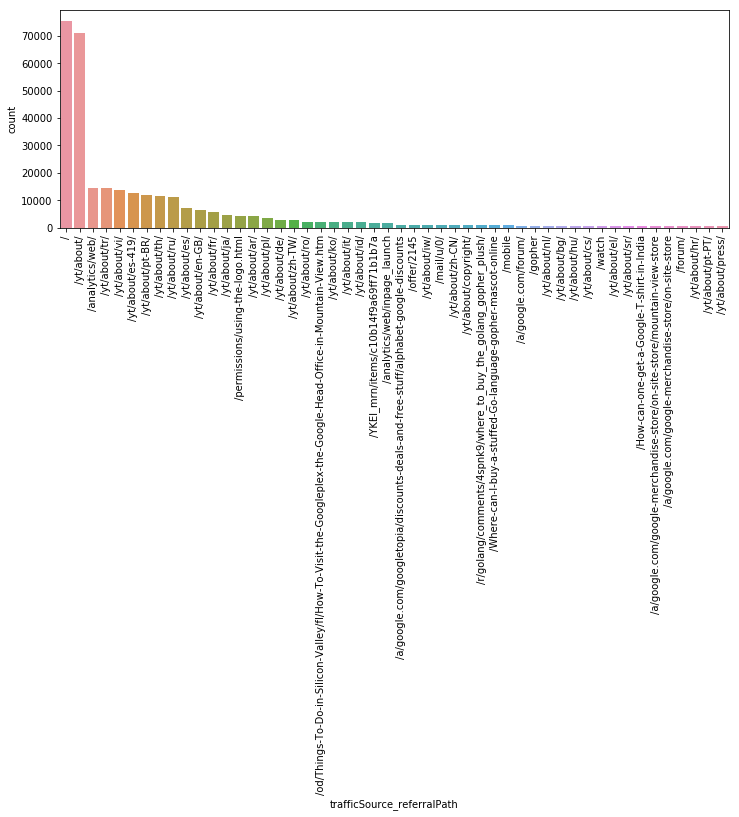

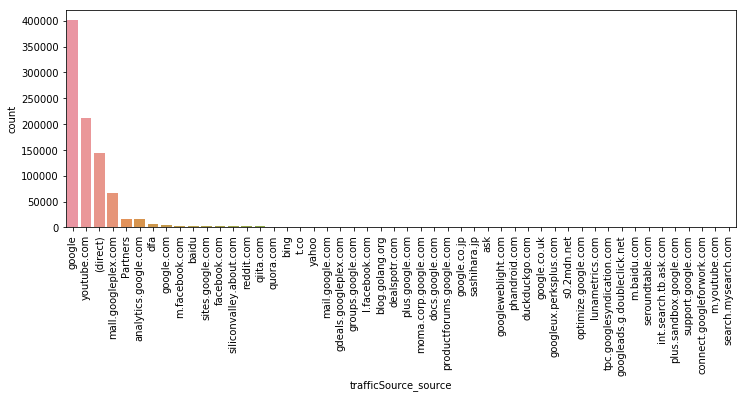

In [78]:
var_cols = [item for item in ts_cols if item not in const_ts_cols]
show_features(train_df,var_cols,12,4)

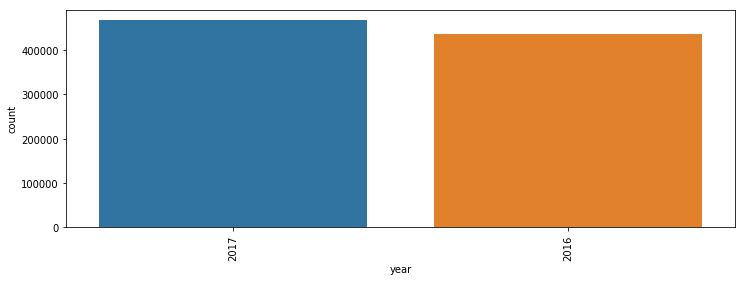

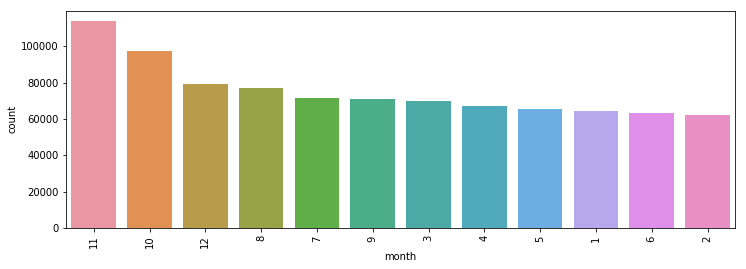

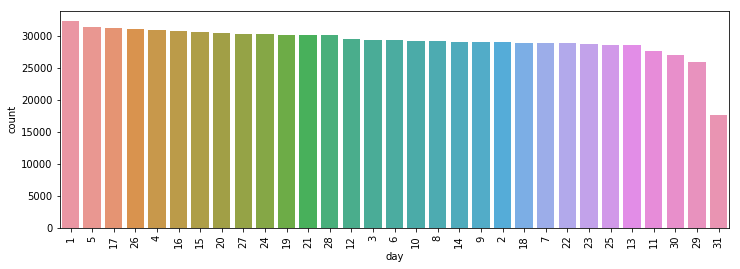

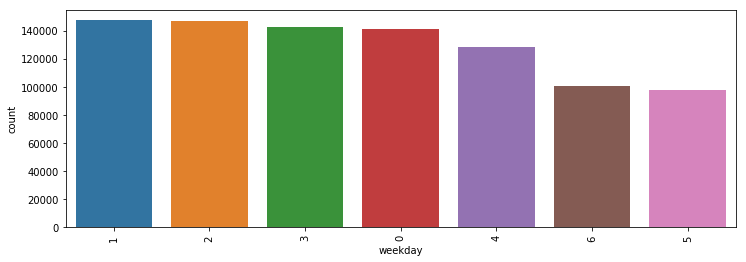

In [79]:
var_cols = ['year','month','day','weekday']
show_features(train_df,var_cols,12,4)

In [82]:
def plot_scatter_data(data, xtitle, ytitle, title, color='blue'):
    trace = go.Scatter(
        x = data.index,
        y = data.values,
        name=ytitle,
        marker=dict(
            color=color,
        ),
        mode='lines+markers'
    )
    data = [trace]
    layout = dict(title = title,
              xaxis = dict(title = xtitle), yaxis = dict(title = ytitle),
             )
    fig = dict(data=data, layout=layout)
    plot(fig, filename='lines')

In [83]:
count_all = train_df.groupby('date')['totals_transactionRevenue'].agg(['size'])
count_all.columns = ["Total"]
count_all = count_all.sort_index()
plot_scatter_data(count_all['Total'],'Date', 'Total','Total count of visits (including zero transactions)','green')

/home/german/.local/lib/python3.5/site-packages/plotly/offline/offline.py:466: UserWarning:

Your filename `lines` didn't end with .html. Adding .html to the end of your file.



In [84]:
count_nonzero = train_df.groupby('date')['totals_transactionRevenue'].agg(['count'])
count_nonzero.columns = ["Total"]
count_nonzero = count_nonzero.sort_index()
plot_scatter_data(count_nonzero['Total'],'Date', 'Total','Total non-zero transaction visits','darkblue')

/home/german/.local/lib/python3.5/site-packages/plotly/offline/offline.py:466: UserWarning:

Your filename `lines` didn't end with .html. Adding .html to the end of your file.



In [85]:
total_nonzero = train_df.groupby('date')['totals_transactionRevenue'].agg(['sum'])
total_nonzero.columns = ["Total"]
total_nonzero = total_nonzero.sort_index()
plot_scatter_data(total_nonzero['Total'],'Date', 'Total','Total non-zero transaction amounts','red')

/home/german/.local/lib/python3.5/site-packages/plotly/offline/offline.py:466: UserWarning:

Your filename `lines` didn't end with .html. Adding .html to the end of your file.



In [86]:
channels = list(train_df['channelGrouping'].unique())
data = []
for channel in channels:
    subset = train_df[train_df['channelGrouping']==channel]
    subset = subset.groupby('date')['totals_transactionRevenue'].agg(['sum'])
    subset.columns = ["Total"]
    subset = subset.sort_index()
    trace = go.Scatter(
        x = subset['Total'].index,
        y = subset['Total'].values,
        name=channel,
        mode='lines'
    )
    data.append(trace)
layout= go.Layout(
    title= 'Total amount of non-zero transactions per day, grouped by channel',
    xaxis = dict(title = 'Date'), yaxis = dict(title = 'Total'),
    showlegend=True,
)
fig = dict(data=data, layout=layout)
plot(fig, filename='lines')

/home/german/.local/lib/python3.5/site-packages/plotly/offline/offline.py:466: UserWarning:

Your filename `lines` didn't end with .html. Adding .html to the end of your file.



'file:///home/german/CPSC_340_kaggle_project-master/lines.html'

In [88]:
#Let's plot the total amount of non-zero transactions per day, grouped by device_operatingSystem.

opsys = list(train_df['device_operatingSystem'].unique())
data = []
for os in opsys:
    subset = train_df[train_df['device_operatingSystem']==os]
    subset = subset.groupby('date')['totals_transactionRevenue'].agg(['sum'])
    subset.columns = ["Total"]
    subset = subset.sort_index()
    trace = go.Scatter(
        x = subset['Total'].index,
        y = subset['Total'].values,
        name=os,
        mode='lines'
    )
    data.append(trace)
layout= go.Layout(
    title= 'Total amount of non-zero transactions per day, grouped by OS',
    xaxis = dict(title = 'Date'), yaxis = dict(title = 'Total'),
    showlegend=True,
)
fig = dict(data=data, layout=layout)
plot(fig, filename='lines')

/home/german/.local/lib/python3.5/site-packages/plotly/offline/offline.py:466: UserWarning:

Your filename `lines` didn't end with .html. Adding .html to the end of your file.



'file:///home/german/CPSC_340_kaggle_project-master/lines.html'

In [89]:
total_test = test_df.groupby('date')['fullVisitorId'].agg(['count'])
total_test.columns = ["Total"]
total_test = total_test.sort_index()
plot_scatter_data(total_test['Total'],'Date', 'Total','Total count of visits per day (test set)','magenta')

/home/german/.local/lib/python3.5/site-packages/plotly/offline/offline.py:466: UserWarning:

Your filename `lines` didn't end with .html. Adding .html to the end of your file.

